In [ ]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import regularizers
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
cols = (['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
            'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
            'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'])

In [ ]:
#Loading training and testing data
train_data = pd.read_csv('/content/KDDTrain+.txt',names = cols)
test_data = pd.read_csv('/content/KDDTest+.txt',names = cols)

## Data Preprocessing


In [ ]:
#Scaling the numerical data
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns=cols)
    return std_df

#Listing out categorical columns for making numerical columns dataframe
cat_cols = ['is_host_login', 'protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_guest_login', 'difficulty', 'label']

# Function for data preprocessing
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)

    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]

    #Assigm=ning 0/1 values to labels columns
    dataframe.loc[dataframe['label'] == "normal", "label"] = 0
    dataframe.loc[dataframe['label'] != 0, "label"] = 1

    dataframe = pd.get_dummies(dataframe, columns=['protocol_type', 'service', 'flag'])
    return dataframe

In [ ]:
# Preprocessing the training dataset
train_scaled = preprocess(train_data)

In [ ]:
# Separatimg features (x) and labels (y)
x = train_scaled.drop(['label', 'difficulty'], axis=1).values
y = train_scaled['label'].values
y_reg = train_scaled['difficulty'].values

In [ ]:
# Imputing missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x = imputer.fit_transform(x)

# Check for NaN values after imputation
if np.isnan(x).any():
    print("Warning: NaN values exist after imputation. Dropping rows with NaN values.")
    nan_rows = np.isnan(x).any(axis=1)
    x = x[~nan_rows]
    y = y[~nan_rows]

# Dimensionality reduction with PCA
pca = PCA(n_components=20)
x_reduced = pca.fit_transform(x)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

# Check for NaN values in the reduced dataset
if np.isnan(x_reduced).any():
    print("Warning: NaN values exist in the reduced dataset. Dropping rows with NaN values.")
    nan_rows_reduced = np.isnan(x_reduced).any(axis=1)
    x_reduced = x_reduced[~nan_rows_reduced]

# Convert labels to integers
y = y.astype('int')

Number of original features is 122 and of reduced features is 20


In [ ]:
# Spliting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_reduced, x_test_reduced, y_train_reduced, y_test_reduced = train_test_split(x_reduced, y, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, test_size=0.2, random_state=42)
print("Number of original features is {} and of reduced features is {}".format(x.shape[1], x_reduced.shape[1]))

Number of original features is 122 and of reduced features is 20


## Model Evaluation

In [ ]:
# Dictionary to store model evaluations for later comparisons
model_evals = dict()

# Function to evaluate classification models
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    if name == "OneClassSVM":
        # For OneClassSVM, we consider only the normal class (0) in evaluation
        y_train = y_train[y_train == 0]
        y_test = y_test[y_test == 0]

    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))

    train_precision = metrics.precision_score(y_train, model.predict(X_train), average='binary')
    test_precision = metrics.precision_score(y_test, model.predict(X_test), average='binary')

    train_recall = metrics.recall_score(y_train, model.predict(X_train), average='binary')
    test_recall = metrics.recall_score(y_test, model.predict(X_test), average='binary')

    model_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Train accuracy for {} is {} and test accuracy is {}".format(name, train_accuracy * 100, test_accuracy * 100))
    print("Train precision for {} is {} and test precision is {}".format(name, train_precision * 100, test_precision * 100))
    print("Train recall for {} is {} and test recall is {}".format(name, train_recall * 100, test_recall * 100))

    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['normal', 'attack'])

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    cm_display.plot(ax=ax)

    return [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]


## KNeighbors Classifier

Train accuracy for KNeighborsClassifier is 99.02260413979242 and test accuracy is 98.8727922206787
Train precision for KNeighborsClassifier is 99.18089029933957 and test precision is 99.01868760133117
Train recall for KNeighborsClassifier is 98.71310583263974 and test recall is 98.56451201902658


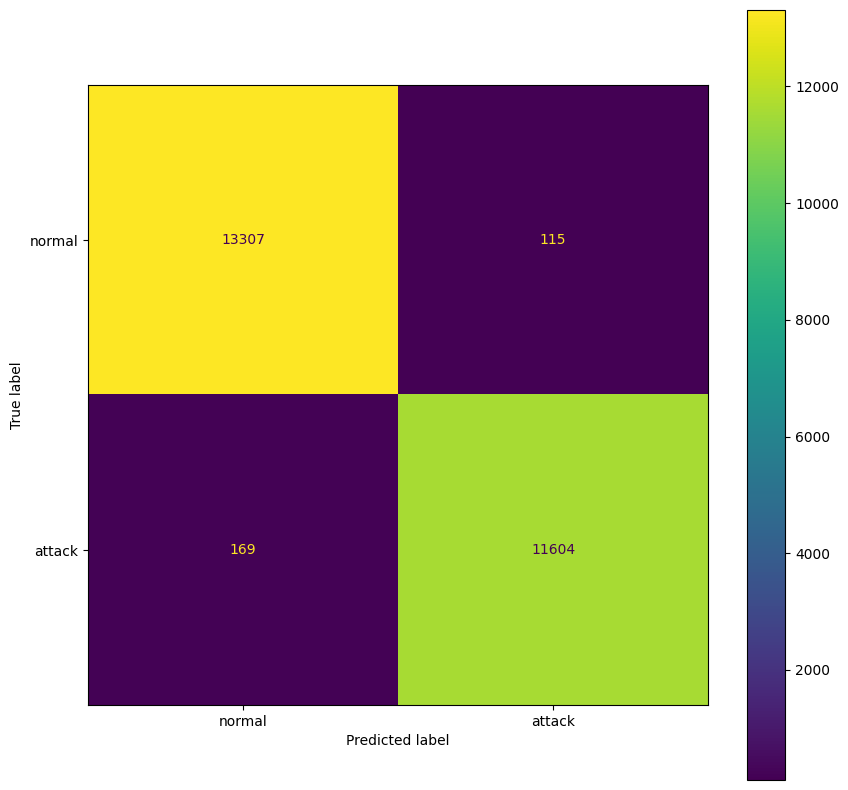

In [ ]:
# A KNeighborsClassifier model with 20 neighbors
knn = KNeighborsClassifier(n_neighbors=20).fit(x_train, y_train)

# Evaluating the KNeighborsClassifier model using the evaluate_classification function
knn_result = evaluate_classification(knn, "KNeighborsClassifier", x_train, x_test, y_train, y_test)

#Storing the result in model_evals dictionary
model_evals["KNN"] = knn_result

## Random Forest Classifier

Train accuracy for RandomForestClassifier is 99.99801543987775 and test accuracy is 99.88489779718198
Train precision for RandomForestClassifier is 99.99786584715197 and test precision is 99.94896223205171
Train recall for RandomForestClassifier is 99.99786584715197 and test recall is 99.80463773040007


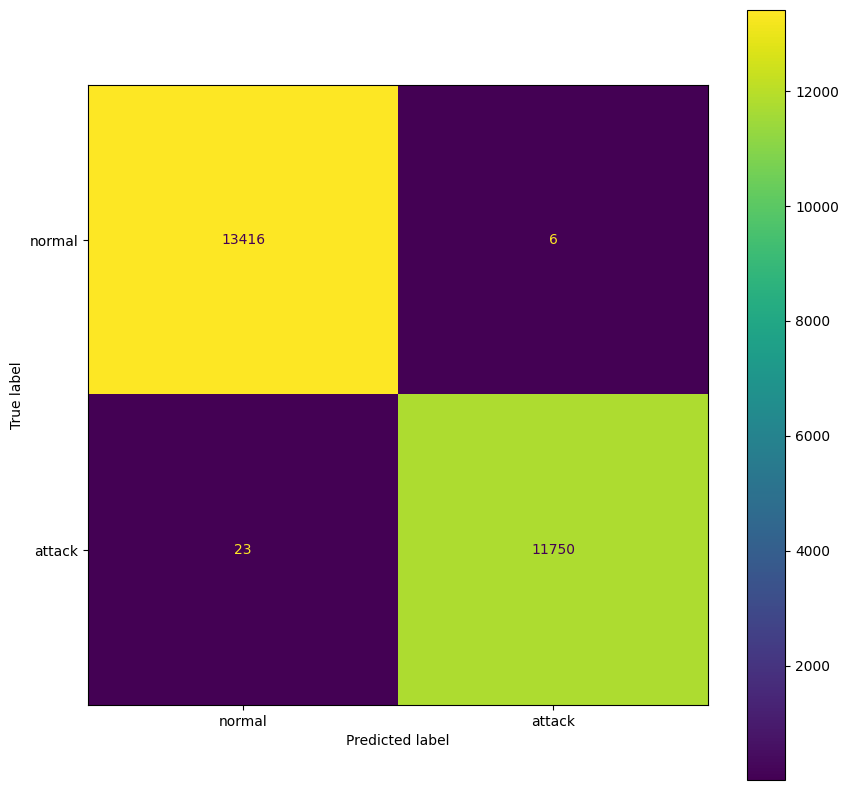

In [ ]:
# Create a RandomForestClassifier model
rf = RandomForestClassifier().fit(x_train, y_train)

# Evaluating the RandomForestClassifier model
rf_result = evaluate_classification(rf, "RandomForestClassifier", x_train, x_test, y_train, y_test)

#Storing the result in model_evals dictionary
model_evals["RandomForestClassifier"] = rf_result

## Displaying the results

In [ ]:
# Displaying the results
model_evals_df = pd.DataFrame.from_dict(model_evals, orient='index', columns=['Train Accuracy', 'Test Accuracy', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall'])
model_evals_df

,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall
KNeighborsClassifier,0.990226,0.988728,0.991809,0.990187,0.987131,0.985645
KNN,0.990226,0.988728,0.991809,0.990187,0.987131,0.985645
RandomForestClassifier,0.999980,0.998849,0.999979,0.999490,0.999979,0.998046


## AutoEncoder Model


In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input

# Function to create and train an autoencoder model
def create_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(20, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

# Function to evaluate the autoencoder model
def evaluate_autoencoder(model, X_train, X_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    mse_train = np.mean(np.power(X_train - train_predictions, 2), axis=1)
    mse_test = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    return mse_train, mse_test

# Train the autoencoder model
autoencoder_input_dim = x_train.shape[1]
autoencoder = create_autoencoder(autoencoder_input_dim)

autoencoder.fit(x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_data=(x_test, x_test), verbose=0)

# Evaluate the autoencoder model
mse_train, mse_test = evaluate_autoencoder(autoencoder, x_train, x_test)

# Add the results to the model_evals dictionary
model_evals["Autoencoder"] = {"MSE Train": mse_train, "MSE Test": mse_test}

# Display the evaluation results
print("Autoencoder evaluation results:")
print("MSE Train: Mean = {:.4f}, Std = {:.4f}".format(np.mean(mse_train), np.std(mse_train)))
print("MSE Test: Mean = {:.4f}, Std = {:.4f}".format(np.mean(mse_test), np.std(mse_test)))


788/788 [==============================] - 1s 1ms/step
Autoencoder evaluation results:
MSE Train: Mean = 4890329.8412, Std = 829202271.0530
MSE Test: Mean = 1750529.0401, Std = 262032035.1145


## One Class SVM Model

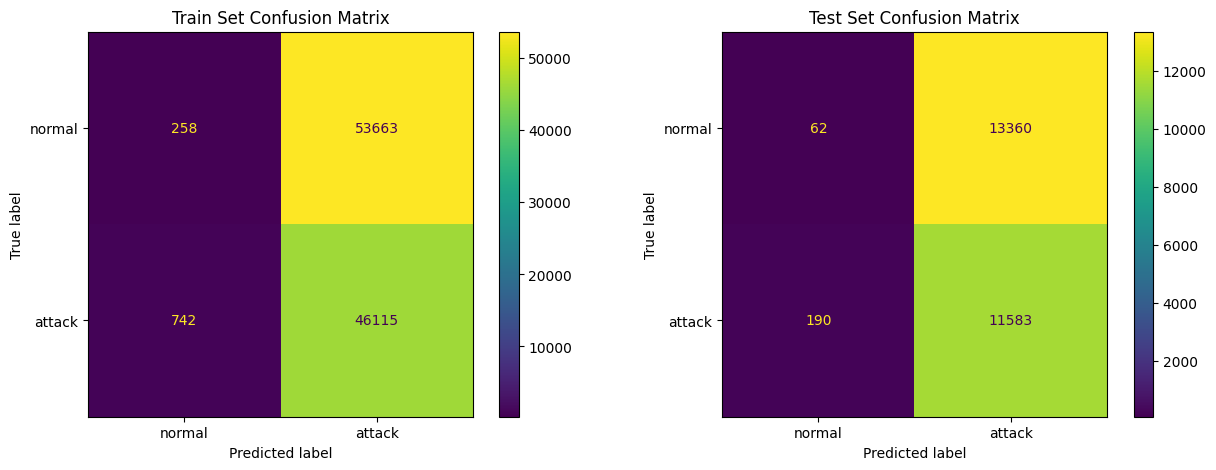

One-Class SVM evaluation results:
Train Accuracy: 0.460150032745242
Test Accuracy: 0.46219487993649533
Train Precision: 0.4621760307883501
Test Precision: 0.4643787836266688
Train Recall: 0.9841645858676399
Test Recall: 0.9838613777287013


In [ ]:
# Importing the necessary library
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Creating and training the One-Class SVM model
ocsvm = OneClassSVM(nu=0.01)  # Adjust the hyperparameter 'nu' as needed
ocsvm.fit(x_train)

# Function to evaluate the One-Class SVM model
def evaluate_ocsvm(model, X_train, X_test, y_train, y_test):
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Converting predictions to binary labels (1 for inliers, -1 for outliers)
    train_labels = [1 if pred == 1 else 0 for pred in train_predictions]
    test_labels = [1 if pred == 1 else 0 for pred in test_predictions]

    # Evaluation metrics
    train_accuracy = accuracy_score(y_train, train_labels)
    test_accuracy = accuracy_score(y_test, test_labels)

    train_precision = precision_score(y_train, train_labels)
    test_precision = precision_score(y_test, test_labels)

    train_recall = recall_score(y_train, train_labels)
    test_recall = recall_score(y_test, test_labels)

    # Confusion Matrix
    confusion_matrix_train = confusion_matrix(y_train, train_labels)
    confusion_matrix_test = confusion_matrix(y_test, test_labels)

    # Display Confusion Matrices
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train, display_labels=['normal', 'attack'])
    cm_display_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test, display_labels=['normal', 'attack'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.set_title("Train Set Confusion Matrix")
    cm_display_train.plot(ax=ax1)

    ax2.set_title("Test Set Confusion Matrix")
    cm_display_test.plot(ax=ax2)

    plt.show()

    return {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall
    }

# Evaluate the One-Class SVM model
ocsvm_result = evaluate_ocsvm(ocsvm, x_train, x_test, y_train, y_test)

# Store the results in the model_evals dictionary
model_evals["OneClassSVM"] = ocsvm_result

# Display the evaluation results
print("One-Class SVM evaluation results:")
for metric, value in ocsvm_result.items():
    print(f"{metric}: {value}")


## Isolation Forest

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Create Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Train-test split
x_train_iso, x_test_iso, y_train_iso, y_test_iso = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
iso_forest.fit(x_train_iso)

# Predict on training and testing sets
train_preds_iso = iso_forest.predict(x_train_iso)
test_preds_iso = iso_forest.predict(x_test_iso)

# Convert predictions to binary labels (1: inlier, -1: outlier)
train_labels_iso = np.where(train_preds_iso == 1, 0, 1)
test_labels_iso = np.where(test_preds_iso == 1, 0, 1)

# Calculate and print evaluation metrics
train_accuracy_iso = metrics.accuracy_score(y_train_iso, train_labels_iso)
test_accuracy_iso = metrics.accuracy_score(y_test_iso, test_labels_iso)

train_precision_iso = metrics.precision_score(y_train_iso, train_labels_iso)
test_precision_iso = metrics.precision_score(y_test_iso, test_labels_iso)

train_recall_iso = metrics.recall_score(y_train_iso, train_labels_iso)
test_recall_iso = metrics.recall_score(y_test_iso, test_labels_iso)

print("Isolation Forest Evaluation Metrics:")
print("Training Accuracy: {:.2f}%".format(train_accuracy_iso * 100))
print("Testing Accuracy: {:.2f}%".format(test_accuracy_iso * 100))
print("Training Precision: {:.2f}".format(train_precision_iso))
print("Testing Precision: {:.2f}".format(test_precision_iso))
print("Training Recall: {:.2f}".format(train_recall_iso))
print("Testing Recall: {:.2f}".format(test_recall_iso))

# Display confusion matrices or any other relevant information


Isolation Forest Evaluation Metrics:
Training Accuracy: 55.25%
Testing Accuracy: 54.95%
Training Precision: 0.67
Testing Precision: 0.67
Training Recall: 0.07
Testing Recall: 0.07
